In [2]:
import pandas as pd
import numpy as np
import sqlalchemy
import csv
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import sqlite3 as sql
from sqlalchemy import create_engine, MetaData, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float, ForeignKey
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier



# Creating SQLlite Table Structure

In [3]:
# Create Engine
### BEGIN SOLUTION
engine = create_engine("sqlite:///survivalprediction.sqlite")


### END SOLUTION

In [4]:
# Use `declarative_base` from SQLAlchemy to model table as an ORM class
# Make sure to specify types for each column

# Declare a Base object here
### BEGIN SOLUTION
Base = declarative_base()

### END SOLUTION

In [5]:
conn = engine.connect()
conn.text_factory = str

In [6]:
# Define the ORM class
### BEGIN SOLUTION
class Surv(Base):
    
    __tablename__ = 'prediction'
    
    Primary_Key = Column(Integer, primary_key=True, unique=True)
    Age = Column(String(20))
    Cancer_Stage = Column(String(10))
    Gender = Column(String(10))
    Cancer_Site = Column(String(25))
    Race = Column(String(50))
    Median_Household_Income = Column(String(25))
    Cancer_Type = Column(String(50))

                      
### END SOLUTION

In [7]:
# Use `create_all` to create the tables
### BEGIN SOLUTION
Base.metadata.create_all(engine)
### END SOLUTION

In [8]:
inspector = inspect(engine)

In [9]:
table_names = inspector.get_table_names()
print(table_names)

['prediction']


In [10]:
columns = inspector.get_columns('prediction')
for column in columns:
    print(column["name"], column["type"])

Primary_Key INTEGER
Age VARCHAR(20)
Cancer_Stage VARCHAR(10)
Gender VARCHAR(10)
Cancer_Site VARCHAR(25)
Race VARCHAR(50)
Median_Household_Income VARCHAR(25)
Cancer_Type VARCHAR(50)


# Data Load/Cleaning Before Machine Learning & DB Creation

In [11]:
# Loading files in
file = "resources/tester.txt"
data = 'Tester.txt'

In [12]:
# Read csv
Survival = pd.read_csv(data, encoding = 'utf8')

C:\Users\shawn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
# Create dataframe with newly appended data
Survival_DF = pd.DataFrame(Survival)

In [14]:
# Show DF
Survival_DF.head(5)

,Sex,Age recode with single ages and 85+,Median household income inflation adj to 2018,Histology recode - broad groupings,"Derived AJCC Stage Group, 7th ed (2010-2015)",Survival months,"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",CS Schema - AJCC 6th Edition
0,Male,73 years,"$75,000+",8140-8389: adenomas and adenocarcinomas,I,0082,Non-Hispanic White,Prostate
1,Male,66 years,"$75,000+",8140-8389: adenomas and adenocarcinomas,IIB,0061,Non-Hispanic White,Prostate
2,Female,54 years,"$75,000+",8500-8549: ductal and lobular neoplasms,IIA,0024,Non-Hispanic White,Breast
3,Female,82 years,"$75,000+",8500-8549: ductal and lobular neoplasms,IA,0063,Non-Hispanic White,Breast
4,Female,56 years,"$75,000+",8500-8549: ductal and lobular neoplasms,IA,0045,Non-Hispanic White,Breast


In [15]:
# Rename columns
Survival_DF2 = Survival_DF.rename(columns={'Sex': 'Gender', 'Age recode with single ages and 85+':'Age',
       'Median household income inflation adj to 2018':'Median_Household_Income','Histology recode - broad groupings':'Cancer_Type',
       'Derived AJCC Stage Group, 7th ed (2010-2015)':'Cancer_Stage', 'Survival months':'Survival_Months',
       'Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)':'Race','CS Schema - AJCC 6th Edition': 'Cancer_Site'})

In [16]:
# Cleaning up DF 
Survival_DF2 = Survival_DF2.loc[Survival_DF2['Survival_Months'] != 'Unknown']
Survival_DF2 = Survival_DF2.loc[Survival_DF2['Age'] != 'Unknown']
Survival_DF2['Age'] = Survival_DF2['Age'].str.replace(' years','')
Survival_DF2['Age'] = Survival_DF2['Age'].str.replace('+','')
Survival_DF2['Median_Household_Income'] = Survival_DF2['Median_Household_Income'].str.replace('Unknown/missing/no match/Not 1990-2017','Unknown')

<ipython-input-16-4f496eb48e72>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  Survival_DF2['Age'] = Survival_DF2['Age'].str.replace('+','')


In [17]:
# Collect DF columns
Survival_DF2.columns

Index(['Gender', 'Age', 'Median_Household_Income', 'Cancer_Type',
       'Cancer_Stage', 'Survival_Months', 'Race', 'Cancer_Site'],
      dtype='object')

In [18]:
# Change the type of of object in the column
Survival_DF2['Cancer_Type'] = Survival_DF2['Cancer_Type'].astype(str)

In [19]:
# Split the string in the column
Survival_DF2['Cancer_Type'] = Survival_DF2['Cancer_Type'].str.split(':').str[1]

In [20]:
# Capitalize first letter of each word in 'Cancer Type column'
Survival_DF2['Cancer_Type'] = Survival_DF2['Cancer_Type'].str.title()

In [21]:
# Change the type of of object in the column
Survival_DF2['Survival_Months'] = pd.to_numeric(Survival_DF2['Survival_Months'])
Survival_DF2['Age'] = pd.to_numeric(Survival_DF2['Age'])
Survival_DF2['Age'].dtype

dtype('int64')

In [22]:
# Display new cleaned DF
Survival_DF2.head()

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Survival_Months,Race,Cancer_Site
0,Male,73,"$75,000+",Adenomas And Adenocarcinomas,I,82,Non-Hispanic White,Prostate
1,Male,66,"$75,000+",Adenomas And Adenocarcinomas,IIB,61,Non-Hispanic White,Prostate
2,Female,54,"$75,000+",Ductal And Lobular Neoplasms,IIA,24,Non-Hispanic White,Breast
3,Female,82,"$75,000+",Ductal And Lobular Neoplasms,IA,63,Non-Hispanic White,Breast
4,Female,56,"$75,000+",Ductal And Lobular Neoplasms,IA,45,Non-Hispanic White,Breast


In [23]:
# Drop all rows with missing information
df_clean_data = Survival_DF2.dropna(how='any')

In [24]:
#Iterate through rows to identify what columns have null values
for column in df_clean_data.columns:
    print(f"Column {column} has {df_clean_data[column].isnull().sum()} null values")

Column Gender has 0 null values
Column Age has 0 null values
Column Median_Household_Income has 0 null values
Column Cancer_Type has 0 null values
Column Cancer_Stage has 0 null values
Column Survival_Months has 0 null values
Column Race has 0 null values
Column Cancer_Site has 0 null values


In [25]:
# Cleaned new DF
df_clean_data.head()

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Survival_Months,Race,Cancer_Site
0,Male,73,"$75,000+",Adenomas And Adenocarcinomas,I,82,Non-Hispanic White,Prostate
1,Male,66,"$75,000+",Adenomas And Adenocarcinomas,IIB,61,Non-Hispanic White,Prostate
2,Female,54,"$75,000+",Ductal And Lobular Neoplasms,IIA,24,Non-Hispanic White,Breast
3,Female,82,"$75,000+",Ductal And Lobular Neoplasms,IA,63,Non-Hispanic White,Breast
4,Female,56,"$75,000+",Ductal And Lobular Neoplasms,IA,45,Non-Hispanic White,Breast


# SQLlite DB Creation

In [26]:
Survival_DF3 = df_clean_data.drop(['Survival_Months'], axis=1)

In [27]:
Final = Survival_DF3.drop_duplicates()
Final.head()

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Race,Cancer_Site
0,Male,73,"$75,000+",Adenomas And Adenocarcinomas,I,Non-Hispanic White,Prostate
1,Male,66,"$75,000+",Adenomas And Adenocarcinomas,IIB,Non-Hispanic White,Prostate
2,Female,54,"$75,000+",Ductal And Lobular Neoplasms,IIA,Non-Hispanic White,Breast
3,Female,82,"$75,000+",Ductal And Lobular Neoplasms,IA,Non-Hispanic White,Breast
4,Female,56,"$75,000+",Ductal And Lobular Neoplasms,IA,Non-Hispanic White,Breast


In [28]:
Base.metadata.create_all(engine)

In [29]:
#Convert csv data to dictionary
CancerSurvival = Final.to_dict(orient='records')
#View first row of dictionary
CancerSurvival[0]

{'Gender': 'Male',
 'Age': 73,
 'Median_Household_Income': '$75,000+',
 'Cancer_Type': ' Adenomas And Adenocarcinomas',
 'Cancer_Stage': 'I',
 'Race': 'Non-Hispanic White',
 'Cancer_Site': 'Prostate'}

In [30]:
metadata = MetaData(bind=engine)
metadata.reflect()

In [31]:
#Create sqlalchemy table
SurvivalTable = sqlalchemy.Table('prediction', metadata, autoload=True)

In [32]:
#Insert dictionary data into sqlalchemy table
conn.execute(SurvivalTable.insert(), CancerSurvival)

In [33]:
#View sqlalchemy table data
conn.execute("select * from prediction").fetchall()

[(1, '73', 'I', 'Male', 'Prostate', 'Non-Hispanic White', '$75,000+', ' Adenomas And Adenocarcinomas'),
 (2, '66', 'IIB', 'Male', 'Prostate', 'Non-Hispanic White', '$75,000+', ' Adenomas And Adenocarcinomas'),
 (3, '54', 'IIA', 'Female', 'Breast', 'Non-Hispanic White', '$75,000+', ' Ductal And Lobular Neoplasms'),
 (4, '82', 'IA', 'Female', 'Breast', 'Non-Hispanic White', '$75,000+', ' Ductal And Lobular Neoplasms'),
 (5, '56', 'IA', 'Female', 'Breast', 'Non-Hispanic White', '$75,000+', ' Ductal And Lobular Neoplasms'),
 (6, '85', 'I', 'Male', 'Bladder', 'Non-Hispanic White', '$75,000+', ' Transitional Cell Papillomas And Carcinomas'),
 (7, '67', 'IIIB', 'Female', 'Rectum', 'Non-Hispanic Asian or Pacific Islander', '$75,000+', ' Adenomas And Adenocarcinomas'),
 (8, '85', 'IIIB', 'Female', 'Breast', 'Non-Hispanic Black', '$75,000+', ' Epithelial Neoplasms, Nos'),
 (9, '71', 'IA', 'Female', 'Breast', 'Hispanic (All Races)', '$75,000+', ' Ductal And Lobular Neoplasms'),
 (10, '76', 'IV', 

# Flask Test

In [34]:
engine = create_engine("sqlite:///survivalprediction.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save reference to the table
CS = Base.classes.prediction

In [35]:
session = Session(engine)

Cancer Site

In [36]:
# Query for unique cancer site names
cancer_site_results = session.query(CS.Cancer_Site).distinct()

In [37]:
    session.close()

    cancer_site_list = []
    for Cancer_Site in cancer_site_results:
        cancer_site_dict = {}
        cancer_site_dict["Cancer_Site"] = Cancer_Site
        cancer_site_list.append(cancer_site_dict)
        

In [38]:
print(cancer_site_list)

[{'Cancer_Site': ('Prostate',)}, {'Cancer_Site': ('Breast',)}, {'Cancer_Site': ('Bladder',)}, {'Cancer_Site': ('Rectum',)}, {'Cancer_Site': ('Lung',)}, {'Cancer_Site': ('Colon',)}, {'Cancer_Site': ('Melanoma',)}, {'Cancer_Site': ('SmallIntestine',)}, {'Cancer_Site': ('Corpus',)}, {'Cancer_Site': ('Stomach',)}, {'Cancer_Site': ('Kidney',)}, {'Cancer_Site': ('Thyroid',)}, {'Cancer_Site': ('Ovary',)}, {'Cancer_Site': ('Lymphoma',)}, {'Cancer_Site': ('SkinEyelid',)}, {'Cancer_Site': ('MF',)}, {'Cancer_Site': ('SoftTissue',)}, {'Cancer_Site': ('Vulva',)}, {'Cancer_Site': ('Urethra',)}, {'Cancer_Site': ('PancreasHead',)}, {'Cancer_Site': ('PancreasBodyTail',)}, {'Cancer_Site': ('Pleura',)}, {'Cancer_Site': ('BaseTongue',)}, {'Cancer_Site': ('Skin',)}, {'Cancer_Site': ('SupraLarynx',)}, {'Cancer_Site': ('OthPancreas',)}, {'Cancer_Site': ('Liver',)}, {'Cancer_Site': ('Anus',)}, {'Cancer_Site': ('GumUpper',)}, {'Cancer_Site': ('GumLower',)}, {'Cancer_Site': ('Oropharynx',)}, {'Cancer_Site': ('E

Median Household Income

In [39]:
Median_Household_Income_Results = session.query(CS.Median_Household_Income).distinct()

In [40]:
    session.close()

    median_household_income_list = []
    for Median_Household_Income in Median_Household_Income_Results:
        median_household_income_dict = {}
        median_household_income_dict["Median_Household_Income"] = Median_Household_Income
        median_household_income_list.append(median_household_income_dict)
        
print(median_household_income_list)

[{'Median_Household_Income': ('$75,000+',)}, {'Median_Household_Income': ('$65,000 - $69,999',)}, {'Median_Household_Income': ('$70,000 - $74,999',)}, {'Median_Household_Income': ('$60,000 - $64,999',)}, {'Median_Household_Income': ('$55,000 - $59,999',)}, {'Median_Household_Income': ('$40,000 - $44,999',)}, {'Median_Household_Income': ('$45,000 - $49,999',)}, {'Median_Household_Income': ('$50,000 - $54,999',)}, {'Median_Household_Income': ('$35,000 - $39,999',)}, {'Median_Household_Income': ('< $35,000',)}, {'Median_Household_Income': ('Unknown',)}]


Race

In [41]:
Race_Results = session.query(CS.Race).distinct()

In [42]:
    session.close()

    race_list = []
    for Race in Race_Results:
        race_dict = {}
        race_dict["Race"] = Race
        race_list.append(race_dict)
        
print(race_list)

[{'Race': ('Non-Hispanic White',)}, {'Race': ('Non-Hispanic Asian or Pacific Islander',)}, {'Race': ('Non-Hispanic Black',)}, {'Race': ('Hispanic (All Races)',)}, {'Race': ('Non-Hispanic American Indian/Alaska Native',)}, {'Race': ('Non-Hispanic Unknown Race',)}]


Cancer Stage

In [43]:
Cancer_Stage_Results = session.query(CS.Cancer_Stage).distinct()

In [44]:
    session.close()

    cancer_stage_list = []
    for Cancer_Stage in Cancer_Stage_Results:
        cancer_stage_dict = {}
        cancer_stage_dict["Cancer_Stage"] = Cancer_Stage
        cancer_stage_list.append(cancer_stage_dict)
        
print(cancer_stage_list)

[{'Cancer_Stage': ('I',)}, {'Cancer_Stage': ('IIB',)}, {'Cancer_Stage': ('IIA',)}, {'Cancer_Stage': ('IA',)}, {'Cancer_Stage': ('IIIB',)}, {'Cancer_Stage': ('IV',)}, {'Cancer_Stage': ('IIIC',)}, {'Cancer_Stage': ('IIIA',)}, {'Cancer_Stage': ('IIIC1',)}, {'Cancer_Stage': ('III',)}, {'Cancer_Stage': ('IB',)}, {'Cancer_Stage': ('IEA',)}, {'Cancer_Stage': ('OCCULT',)}, {'Cancer_Stage': ('0a',)}, {'Cancer_Stage': ('IVB',)}, {'Cancer_Stage': ('IVA',)}, {'Cancer_Stage': ('II',)}, {'Cancer_Stage': ('INOS',)}, {'Cancer_Stage': ('IIINOS',)}, {'Cancer_Stage': ('IIIEA',)}, {'Cancer_Stage': ('IIEA',)}, {'Cancer_Stage': ('IVC',)}, {'Cancer_Stage': ('IIC',)}, {'Cancer_Stage': ('IE',)}, {'Cancer_Stage': ('IIEB',)}, {'Cancer_Stage': ('0is',)}, {'Cancer_Stage': ('IINOS',)}, {'Cancer_Stage': ('IB2',)}, {'Cancer_Stage': ('IIIESB',)}, {'Cancer_Stage': ('0',)}, {'Cancer_Stage': ('IVNOS',)}, {'Cancer_Stage': ('IIIC2',)}, {'Cancer_Stage': ('ISA',)}, {'Cancer_Stage': ('IIE',)}, {'Cancer_Stage': ('IBNOS',)}, {'

Cancer Type

In [45]:
Cancer_Type_Results = session.query(CS.Cancer_Type).distinct()

In [46]:
    session.close()

    cancer_type_list = []
    for Cancer_Type in Cancer_Type_Results:
        cancer_type_dict = {}
        cancer_type_dict["Cancer_Type"] = Cancer_Type
        cancer_type_list.append(cancer_type_dict)
        
print(cancer_type_list)

[{'Cancer_Type': (' Adenomas And Adenocarcinomas',)}, {'Cancer_Type': (' Ductal And Lobular Neoplasms',)}, {'Cancer_Type': (' Transitional Cell Papillomas And Carcinomas',)}, {'Cancer_Type': (' Epithelial Neoplasms, Nos',)}, {'Cancer_Type': (' Nevi And Melanomas',)}, {'Cancer_Type': (' Acinar Cell Neoplasms',)}, {'Cancer_Type': (' Complex Mixed And Stromal Neoplasms',)}, {'Cancer_Type': (' Squamous Cell Neoplasms',)}, {'Cancer_Type': (' Cystic, Mucinous And Serous Neoplasms',)}, {'Cancer_Type': (' Nhl - Mature B-Cell Lymphomas',)}, {'Cancer_Type': (' Adnexal And Skin Appendage Neoplasms',)}, {'Cancer_Type': (' Nhl - Mature T And Nk-Cell Lymphomas',)}, {'Cancer_Type': (' Blood Vessel Tumors',)}, {'Cancer_Type': (' Soft Tissue Tumors And Sarcomas, Nos',)}, {'Cancer_Type': (' Complex Epithelial Neoplasms',)}, {'Cancer_Type': (' Mesothelial Neoplasms',)}, {'Cancer_Type': (' Unspecified Neoplasms',)}, {'Cancer_Type': (' Hodgkin Lymphomas',)}, {'Cancer_Type': (' Mucoepidermoid Neoplasms',)},

Age

In [47]:
Age_Results = session.query(CS.Age).distinct()

In [48]:
    session.close()

    age_list = []
    for Age in Age_Results:
        age_dict = {}
        age_dict["Age"] = Age
        age_list.append(age_dict)
        
print(age_list)

[{'Age': ('73',)}, {'Age': ('66',)}, {'Age': ('54',)}, {'Age': ('82',)}, {'Age': ('56',)}, {'Age': ('85',)}, {'Age': ('67',)}, {'Age': ('71',)}, {'Age': ('76',)}, {'Age': ('60',)}, {'Age': ('75',)}, {'Age': ('69',)}, {'Age': ('80',)}, {'Age': ('70',)}, {'Age': ('59',)}, {'Age': ('84',)}, {'Age': ('61',)}, {'Age': ('52',)}, {'Age': ('64',)}, {'Age': ('68',)}, {'Age': ('57',)}, {'Age': ('53',)}, {'Age': ('49',)}, {'Age': ('45',)}, {'Age': ('46',)}, {'Age': ('72',)}, {'Age': ('83',)}, {'Age': ('74',)}, {'Age': ('58',)}, {'Age': ('62',)}, {'Age': ('81',)}, {'Age': ('79',)}, {'Age': ('78',)}, {'Age': ('55',)}, {'Age': ('77',)}, {'Age': ('63',)}, {'Age': ('44',)}, {'Age': ('35',)}, {'Age': ('23',)}, {'Age': ('34',)}, {'Age': ('65',)}, {'Age': ('41',)}, {'Age': ('50',)}, {'Age': ('51',)}, {'Age': ('42',)}, {'Age': ('40',)}, {'Age': ('48',)}, {'Age': ('38',)}, {'Age': ('47',)}, {'Age': ('39',)}, {'Age': ('43',)}, {'Age': ('25',)}, {'Age': ('37',)}, {'Age': ('31',)}, {'Age': ('20',)}, {'Age': (

Gender

In [49]:
Gender_Results = session.query(CS.Gender).distinct()

In [50]:
    session.close()

    gender_list = []
    for Gender in Gender_Results:
        gender_dict = {}
        gender_dict["Gender"] = Gender
        gender_list.append(gender_dict)
        
print(gender_list)

[{'Gender': ('Male',)}, {'Gender': ('Female',)}]


In [51]:
    session.close()

# Machine Learning Sample Data Frame

In [52]:
# Utilizing a sample of cleaned DF due to length of running our models
df_sample = df_clean_data.sample(frac=.15)
df_sample.head()

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Survival_Months,Race,Cancer_Site
346359,Female,79,"$75,000+",Adenomas And Adenocarcinomas,IIIB,68,Non-Hispanic Asian or Pacific Islander,Colon
289043,Male,60,"$40,000 - $44,999",Adenomas And Adenocarcinomas,IIA,28,Non-Hispanic Black,Prostate
389584,Female,84,"$55,000 - $59,999",Adenomas And Adenocarcinomas,IIIC,23,Non-Hispanic White,Colon
151133,Female,58,"$75,000+",Ductal And Lobular Neoplasms,IIA,8,Hispanic (All Races),Breast
1256080,Male,62,"$75,000+",Adenomas And Adenocarcinomas,I,46,Non-Hispanic White,Prostate


In [53]:
y_sample = df_sample['Survival_Months']
y_sample = y_sample.round()
y_sample

346359     68
289043     28
389584     23
151133      8
1256080    46
           ..
115577     41
821727      3
109954     43
898885     61
960105     34
Name: Survival_Months, Length: 315140, dtype: int64

In [54]:
testing_data_sample = df_sample.drop(['Survival_Months'], axis=1)
testing_data_sample

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Race,Cancer_Site
346359,Female,79,"$75,000+",Adenomas And Adenocarcinomas,IIIB,Non-Hispanic Asian or Pacific Islander,Colon
289043,Male,60,"$40,000 - $44,999",Adenomas And Adenocarcinomas,IIA,Non-Hispanic Black,Prostate
389584,Female,84,"$55,000 - $59,999",Adenomas And Adenocarcinomas,IIIC,Non-Hispanic White,Colon
151133,Female,58,"$75,000+",Ductal And Lobular Neoplasms,IIA,Hispanic (All Races),Breast
1256080,Male,62,"$75,000+",Adenomas And Adenocarcinomas,I,Non-Hispanic White,Prostate
...,...,...,...,...,...,...,...
115577,Male,64,"$75,000+",Adenomas And Adenocarcinomas,IA,Non-Hispanic White,Lung
821727,Female,60,"$60,000 - $64,999",Ductal And Lobular Neoplasms,IV,Hispanic (All Races),Breast
109954,Male,74,"$65,000 - $69,999",Adenomas And Adenocarcinomas,IIA,Non-Hispanic White,Ampulla
898885,Male,63,"$55,000 - $59,999",Adenomas And Adenocarcinomas,I,Hispanic (All Races),Kidney


In [55]:
X_sample = pd.get_dummies(testing_data_sample)
X_sample

,Age,Gender_Female,Gender_Male,"Median_Household_Income_$35,000 - $39,999","Median_Household_Income_$40,000 - $44,999","Median_Household_Income_$45,000 - $49,999","Median_Household_Income_$50,000 - $54,999","Median_Household_Income_$55,000 - $59,999","Median_Household_Income_$60,000 - $64,999","Median_Household_Income_$65,000 - $69,999",...,Cancer_Site_SoftTissue,Cancer_Site_Stomach,Cancer_Site_SubLarynx,Cancer_Site_SubmandibularGland,Cancer_Site_SupraLarynx,Cancer_Site_Testis,Cancer_Site_Thyroid,Cancer_Site_Urethra,Cancer_Site_Vagina,Cancer_Site_Vulva
346359,79,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289043,60,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389584,84,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151133,58,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1256080,62,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115577,64,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
821727,60,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
109954,74,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
898885,63,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Supervised Machine Learning

### Random Forest Classifier

In [66]:
#Creating three categories to prepare data for classification
df_sample.loc[df_sample['Survival_Months'] <7, 'Survival Groups'] = '0-6 Months'
df_sample.loc[(df_sample['Survival_Months'] >=7) & (df_sample['Survival_Months'] <= 12), 'Survival Groups'] = '7-12 Months'
df_sample.loc[df_sample['Survival_Months'] >12, 'Survival Groups'] = '> 12 Months'
df_sample

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Survival_Months,Race,Cancer_Site,Survival Groups
346359,Female,79,"$75,000+",Adenomas And Adenocarcinomas,IIIB,68,Non-Hispanic Asian or Pacific Islander,Colon,> 12 Months
289043,Male,60,"$40,000 - $44,999",Adenomas And Adenocarcinomas,IIA,28,Non-Hispanic Black,Prostate,> 12 Months
389584,Female,84,"$55,000 - $59,999",Adenomas And Adenocarcinomas,IIIC,23,Non-Hispanic White,Colon,> 12 Months
151133,Female,58,"$75,000+",Ductal And Lobular Neoplasms,IIA,8,Hispanic (All Races),Breast,7-12 Months
1256080,Male,62,"$75,000+",Adenomas And Adenocarcinomas,I,46,Non-Hispanic White,Prostate,> 12 Months
...,...,...,...,...,...,...,...,...,...
115577,Male,64,"$75,000+",Adenomas And Adenocarcinomas,IA,41,Non-Hispanic White,Lung,> 12 Months
821727,Female,60,"$60,000 - $64,999",Ductal And Lobular Neoplasms,IV,3,Hispanic (All Races),Breast,0-6 Months
109954,Male,74,"$65,000 - $69,999",Adenomas And Adenocarcinomas,IIA,43,Non-Hispanic White,Ampulla,> 12 Months
898885,Male,63,"$55,000 - $59,999",Adenomas And Adenocarcinomas,I,61,Hispanic (All Races),Kidney,> 12 Months


In [67]:
#Create y with new 'Survival Groups' column
y_sample = df_sample['Survival Groups']

#Encode Y_Train and Y_Test
y_sample = LabelEncoder().fit_transform(df_sample['Survival Groups'])

y_sample

array([2, 2, 2, ..., 2, 2, 2])

In [68]:
#Drop old target and new target columns
testing_data_sample = df_sample.drop(['Survival_Months'], axis=1)
testing_data_sample = testing_data_sample.drop(['Survival Groups'], axis=1)

testing_data_sample

,Gender,Age,Median_Household_Income,Cancer_Type,Cancer_Stage,Race,Cancer_Site
346359,Female,79,"$75,000+",Adenomas And Adenocarcinomas,IIIB,Non-Hispanic Asian or Pacific Islander,Colon
289043,Male,60,"$40,000 - $44,999",Adenomas And Adenocarcinomas,IIA,Non-Hispanic Black,Prostate
389584,Female,84,"$55,000 - $59,999",Adenomas And Adenocarcinomas,IIIC,Non-Hispanic White,Colon
151133,Female,58,"$75,000+",Ductal And Lobular Neoplasms,IIA,Hispanic (All Races),Breast
1256080,Male,62,"$75,000+",Adenomas And Adenocarcinomas,I,Non-Hispanic White,Prostate
...,...,...,...,...,...,...,...
115577,Male,64,"$75,000+",Adenomas And Adenocarcinomas,IA,Non-Hispanic White,Lung
821727,Female,60,"$60,000 - $64,999",Ductal And Lobular Neoplasms,IV,Hispanic (All Races),Breast
109954,Male,74,"$65,000 - $69,999",Adenomas And Adenocarcinomas,IIA,Non-Hispanic White,Ampulla
898885,Male,63,"$55,000 - $59,999",Adenomas And Adenocarcinomas,I,Hispanic (All Races),Kidney


In [69]:
#Convert x values to dummy values
X_dummies = pd.get_dummies(testing_data_sample)
X_dummies

,Age,Gender_Female,Gender_Male,"Median_Household_Income_$35,000 - $39,999","Median_Household_Income_$40,000 - $44,999","Median_Household_Income_$45,000 - $49,999","Median_Household_Income_$50,000 - $54,999","Median_Household_Income_$55,000 - $59,999","Median_Household_Income_$60,000 - $64,999","Median_Household_Income_$65,000 - $69,999",...,Cancer_Site_SoftTissue,Cancer_Site_Stomach,Cancer_Site_SubLarynx,Cancer_Site_SubmandibularGland,Cancer_Site_SupraLarynx,Cancer_Site_Testis,Cancer_Site_Thyroid,Cancer_Site_Urethra,Cancer_Site_Vagina,Cancer_Site_Vulva
346359,79,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289043,60,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389584,84,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151133,58,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1256080,62,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115577,64,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
821727,60,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
109954,74,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
898885,63,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
X_sample = X_dummies

In [72]:
X = X_sample
y = y_sample

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [73]:
#Run classification model
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train, y_train)
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 0.9313236445177805
Testing Score: 0.8019039157199974


In [ ]:
# Placing our predication data in CSV
predication_data = pd.Series(0,index=X_train.columns)
predication_data.to_csv('resources/Blank_Form.csv')

In [ ]:
# Creating a model to read csv inputs from webiste
model.predict(np.reshape(np.array(predication_data.values.tolist()),(1,198)))

In [ ]:
# The model and its placed in apy file as well
def modelFunction(model_name, model):
    import pickle 
    with open(str(model_name), "wb") as f:
        pickle.dump(model,f)

In [ ]:
# Model function
modelFunction("resources/model.pkl", model)

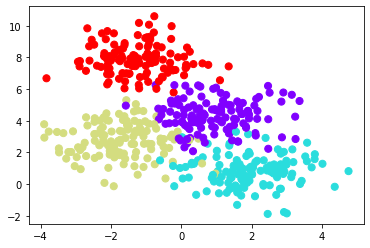

In [74]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')

##### All the code below was our trial and error period fro different models. We tried utilizing full data sets and it caused the model to run almost for 20-30+ minutes. After models were ran we still recieved similar scores to samples. All of the code in the next cell isn't needed, but there for learning purposes.

In [ ]:
#### Linear Regression Model

# y = df_clean_data['Survival_Months']
# testing_data = df_clean_data.drop('Survival_Months', axis=1)
# X = pd.get_dummies(testing_data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# model.fit(X_train, y_train)
# print(f"Training Data Score: {model.score(X_train, y_train)}")
# print(f"Testing Data Score: {model.score(X_test, y_test)}")

In [ ]:
#### Random Forest Model

# model = GradientBoostingRegressor()
# model.fit(X_train, y_train)
# print(f"Training Data Score: {model.score(X_train, y_train)}")
# print(f"Testing Data Score: {model.score(X_test, y_test)}")
# predicated = model.predict(X_test)
# mean_absolute_error(y_test,predicated)